In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

def disp_dataset(ds, limit=None, print_elements=True):
    count = 0

    for x in ds:
        count += 1
        if print_elements:
            print(x)
        if limit is not None and count >= limit:
            break
    print(f"Count:{count}")


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


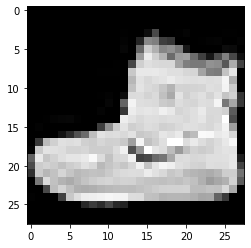

In [35]:
def show_image(images):
    for img in images:
        plt.figure()
        plt.imshow(img, cmap="gray")
show_image(X_train[:1])


# Entrainer un autoencodeur débruiteur

In [51]:
debruiteur_encodeur = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(stddev=1), # active seulement durent l'entrainement
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu") # On utilise une représentation latente sous-complet
])

debruiteur_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

model_debruiteur = keras.models.Sequential([debruiteur_encodeur, debruiteur_decoder])

# model_debruiteur.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(lr=1.5), metrics=["accuracy"])
model_debruiteur.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics=["accuracy"])
# model_debruiteur.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5), metrics=["mse"])

model_debruiteur.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4115 - accuracy: 0.0625 - val_loss: 0.3230 - val_accuracy: 0.0919
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3345 - accuracy: 0.0852 - val_loss: 0.3217 - val_accuracy: 0.1004
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3307 - accuracy: 0.0874 - val_loss: 0.3143 - val_accuracy: 0.0971
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3270 - accuracy: 0.0910 - val_loss: 0.3117 - val_accuracy: 0.1001
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3249 - accuracy: 0.0934 - val_loss: 0.3107 - val_accuracy: 0.1003
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3236 - accuracy: 0.0945 - val_loss: 0.3101 - val_accuracy: 0.1031
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3231 - accuracy: 0.0966 - val_loss: 0.3075 - val_accuracy:

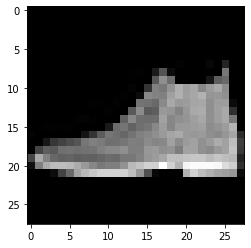

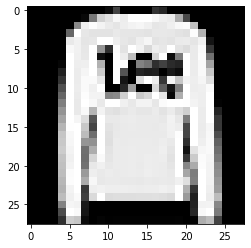

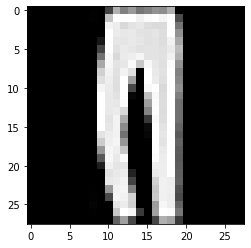

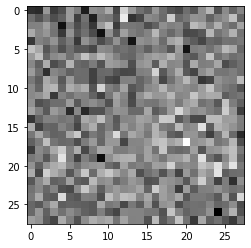

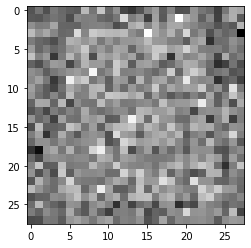

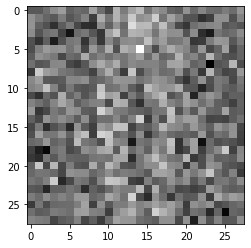

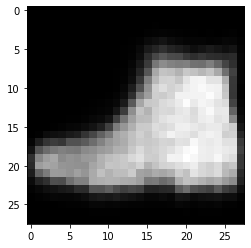

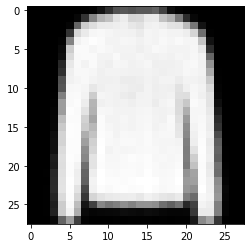

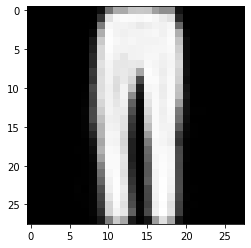

In [54]:
def test_model(model, n=1):
    image = X_test[:n,:,:]
    image_bruite = image + tf.random.normal([n, 28, 28])
    # image_bruite
    debruite = model.predict(image_bruite)
    debruite.shape
    show_image(image)
    show_image(image_bruite)
    show_image(debruite)

test_model(model_debruiteur, n=3)

In [53]:
# Essayons avec un modèle convolutif

conv_encodeur = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.GaussianNoise(stddev=1), # active seulement durent l'entrainement
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="valid", activation="relu", input_shape=[3, 3, 128]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

model_conv = keras.models.Sequential([conv_encodeur, conv_decoder])

# model_debruiteur.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(lr=1.5), metrics=["accuracy"])
model_conv.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics=["accuracy"])

model_conv.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 5ms/step - loss: 0.4647 - accuracy: 0.0526 - val_loss: 0.3277 - val_accuracy: 0.0797
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3359 - accuracy: 0.0770 - val_loss: 0.3107 - val_accuracy: 0.0933
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3286 - accuracy: 0.0859 - val_loss: 0.3044 - val_accuracy: 0.0954
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3261 - accuracy: 0.0915 - val_loss: 0.3015 - val_accuracy: 0.1015
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3236 - accuracy: 0.0968 - val_loss: 0.3032 - val_accuracy: 0.1084
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3223 - accuracy: 0.0997 - val_loss: 0.3006 - val_accuracy: 0.1139
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3212 - accuracy: 0.1024 - val_loss: 0.2988 - val_accurac

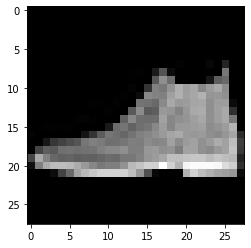

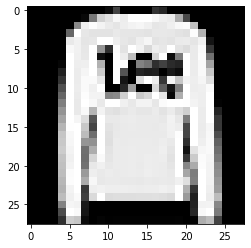

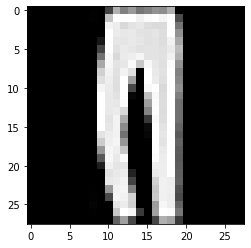

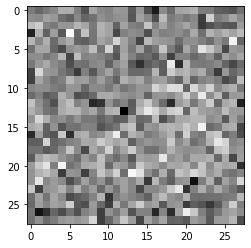

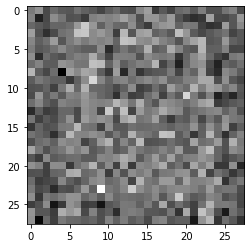

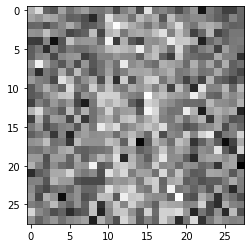

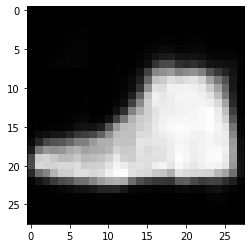

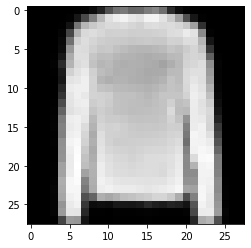

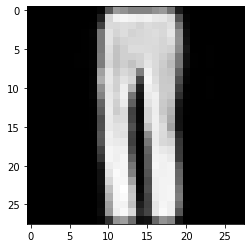

In [56]:
test_model(model_conv, n=3)

# Pré-entrainement non supervisé.
Nous allons créer un modèle de classification binaire qui va ré-utiliser les couches de notre encodeur convolutif. Nous allons faire une comparaison avec pré-entrainement et sans pré-entrainement, mais avec les mêmes couches.

In [60]:
X_train_small = X_train[:500, :, :]
y_train_small = y_train[:500]

conv_encoder_clone = keras.models.clone_model(conv_encodeur) # ne recopie pas les poids

clf_binaire = keras.models.Sequential([
   conv_encoder_clone,
   keras.layers.Flatten(),
   keras.layers.Dense(10, activation="softmax")
])

clf_binaire.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])

# on arrive entre 0.57 et 0.61 de précision
history = clf_binaire.fit(X_train_small, y_train_small, epochs=30, # plus d'époques car on a moins de données
                             validation_data=(X_valid, y_valid))
    

Epoch 1/30
16/16 [==============================] - 1s 33ms/step - loss: 2.3175 - accuracy: 0.1109 - val_loss: 2.2919 - val_accuracy: 0.1194
Epoch 2/30
16/16 [==============================] - 0s 22ms/step - loss: 2.2765 - accuracy: 0.1397 - val_loss: 2.2799 - val_accuracy: 0.2194
Epoch 3/30
16/16 [==============================] - 0s 20ms/step - loss: 2.2403 - accuracy: 0.2625 - val_loss: 2.2613 - val_accuracy: 0.2292
Epoch 4/30
16/16 [==============================] - 0s 20ms/step - loss: 2.1871 - accuracy: 0.2635 - val_loss: 2.2264 - val_accuracy: 0.1294
Epoch 5/30
16/16 [==============================] - 0s 20ms/step - loss: 2.0344 - accuracy: 0.3225 - val_loss: 2.1509 - val_accuracy: 0.1838
Epoch 6/30
16/16 [==============================] - 0s 22ms/step - loss: 1.8147 - accuracy: 0.4615 - val_loss: 2.0141 - val_accuracy: 0.2396
Epoch 7/30
16/16 [==============================] - 0s 17ms/step - loss: 1.5308 - accuracy: 0.5186 - val_loss: 1.8722 - val_accuracy: 0.3130
Epoch 8/30
16

In [68]:
# Avec pré-entrainement

pretrained_clone = keras.models.clone_model(conv_encodeur) # ne recopie pas les poids
pretrained_clone.set_weights(conv_encodeur.get_weights())

clf_binaire_pretrained = keras.models.Sequential([
   pretrained_clone,
   keras.layers.Flatten(),
   keras.layers.Dense(10, activation="softmax")
])

clf_binaire.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])

# on arrive aux alentours de 0.66 de précision, donc on a bien un meilleur résultat dû au pré-entrainement. 
history = clf_binaire.fit(X_train_small, y_train_small, epochs=30, # plus d'époques car on a moins de données
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 1s 28ms/step - loss: 0.9411 - accuracy: 0.6539 - val_loss: 1.3370 - val_accuracy: 0.4504
Epoch 2/30
16/16 [==============================] - 0s 22ms/step - loss: 0.9675 - accuracy: 0.6236 - val_loss: 1.1082 - val_accuracy: 0.6342
Epoch 3/30
16/16 [==============================] - 0s 20ms/step - loss: 0.9332 - accuracy: 0.6474 - val_loss: 1.2015 - val_accuracy: 0.5574
Epoch 4/30
16/16 [==============================] - 0s 23ms/step - loss: 0.9388 - accuracy: 0.6408 - val_loss: 1.0905 - val_accuracy: 0.6276
Epoch 5/30
16/16 [==============================] - 0s 21ms/step - loss: 0.9362 - accuracy: 0.6663 - val_loss: 1.1196 - val_accuracy: 0.6192
Epoch 6/30
16/16 [==============================] - 0s 21ms/step - loss: 0.9393 - accuracy: 0.6367 - val_loss: 1.1878 - val_accuracy: 0.5632
Epoch 7/30
16/16 [==============================] - 0s 22ms/step - loss: 0.8368 - accuracy: 0.7098 - val_loss: 1.1780 - val_accuracy: 0.6186
Epoch 8/30
16

In [73]:
# On pourrait aussi essayer de peaufiner l'entrainement en fixant les poids dans un premier temps puis de les relâcher.

pretrained_clone = keras.models.clone_model(conv_encodeur) # ne recopie pas les poids
pretrained_clone.set_weights(conv_encodeur.get_weights())

clf_binaire_pretrained = keras.models.Sequential([
   pretrained_clone,
   keras.layers.Flatten(),
   keras.layers.Dense(10, activation="softmax")
])

clf_binaire_pretrained.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])


pretrained_clone.trainable = False
history = clf_binaire_pretrained.fit(X_train_small, y_train_small, epochs=15, # plus d'époques car on a moins de données
                             validation_data=(X_valid, y_valid))

pretrained_clone.trainable = True
pretrained_clone.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.01), # On diminue le learning_rate
                       metrics=["accuracy"])
# On voit qu'il n'y a pas vraiment de réelles améliorations par rapport à l'entrainement en une fois.
history = clf_binaire_pretrained.fit(X_train_small, y_train_small, epochs=15, # plus d'époques car on a moins de données
                             validation_data=(X_valid, y_valid))

Epoch 1/15
16/16 [==============================] - 1s 26ms/step - loss: 4.1538 - accuracy: 0.2877 - val_loss: 1.5769 - val_accuracy: 0.5350
Epoch 2/15
16/16 [==============================] - 0s 20ms/step - loss: 1.2954 - accuracy: 0.5856 - val_loss: 1.0780 - val_accuracy: 0.6484
Epoch 3/15
16/16 [==============================] - 0s 19ms/step - loss: 1.0967 - accuracy: 0.6041 - val_loss: 0.9048 - val_accuracy: 0.6782
Epoch 4/15
16/16 [==============================] - 0s 18ms/step - loss: 1.0339 - accuracy: 0.6326 - val_loss: 0.8686 - val_accuracy: 0.6924
Epoch 5/15
16/16 [==============================] - 0s 25ms/step - loss: 0.9129 - accuracy: 0.6673 - val_loss: 0.7996 - val_accuracy: 0.6972
Epoch 6/15
16/16 [==============================] - 0s 21ms/step - loss: 1.0185 - accuracy: 0.6689 - val_loss: 0.9331 - val_accuracy: 0.6814
Epoch 7/15
16/16 [==============================] - 0s 19ms/step - loss: 0.9017 - accuracy: 0.6736 - val_loss: 0.7460 - val_accuracy: 0.7312
Epoch 8/15
16

# Entrainer un autoencodeur variationnel et générer des images de fashion-MNIST

In [74]:
K = keras.backend

# Il s'agit là du décodeur variationnel du livre

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

codings_size = 30
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
# On se trouve avant la couche de codage

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])


_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 2s 3ms/step - loss: 0.4457 - accuracy: 0.0666 - val_loss: 0.3587 - val_accuracy: 0.0885
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3494 - accuracy: 0.0914 - val_loss: 0.3460 - val_accuracy: 0.0999
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3350 - accuracy: 0.1013 - val_loss: 0.3327 - val_accuracy: 0.1191
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3299 - accuracy: 0.1076 - val_loss: 0.3265 - val_accuracy: 0.1124
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3258 - accuracy: 0.1145 - val_loss: 0.3248 - val_accuracy: 0.1184
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3233 - accuracy: 0.1177 - val_loss: 0.3246 - val_accuracy: 0.1218
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3216 - accuracy: 0.1220 - val_loss: 0.3226 - val_accuracy: 0.1245
Epoch 

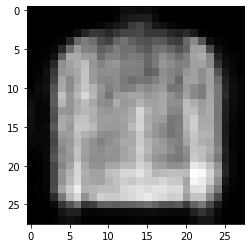

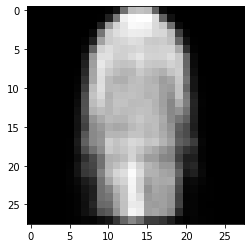

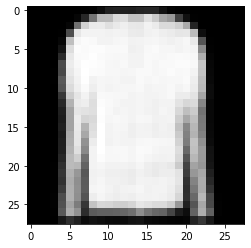

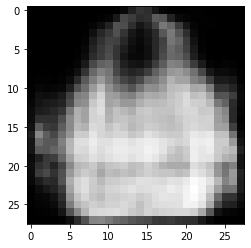

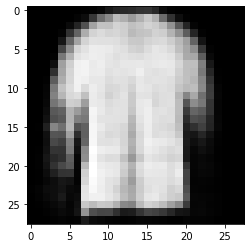

In [109]:
def gen_images(model, codings_size=codings_size, n=5):
    noises = tf.random.normal([n, codings_size])
    generated = model(noises).numpy()
    show_image(generated)
    
gen_images(variational_decoder, n=5)
 # On voit que dans l'ensemble ça ressemble, mais y'a quand même pas mal de bruits, et surtout, et il y a des soucis de cohérence globales, comme indiqué dans le livre, par exemple des manches plus longues que d'autres

# Génération d'images avec GAN

In [77]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Il s'agit de la boucle d'entrainement pour gan décrite dans le livre
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)


In [164]:
# Un gan simple
codings_size = 30
def create_simple_gan(codings_size = 30):
    # Il prend une représentation latente comme entrée, et doit reconstruire une image avec
    generator = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ])
    # Prend une image et doit indiquer si elle est réelle ou non
    discriminator = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    gan = keras.models.Sequential([generator, discriminator])

    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    discriminator.trainable = False
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return gan, generator, discriminator


In [ ]:
gan, generator, discriminator = create_simple_gan()
train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

In [190]:
# from sklearn.metrics import accuracy_score

def accuracy_score(y_pred, y_true):
    m = tf.keras.metrics.Accuracy()
    m.update_state(y_pred, y_true)
    return m.result().numpy()

def test_discriminator(gan, test_size=100, reshape=False):
    generator, discriminator = gan.layers
    unit_size = int(test_size / 2)
    noise = tf.random.normal(shape=[unit_size, codings_size])
    X_fake = generator(noise)

    if reshape:
        X_fake = tf.reshape(X_fake, X_fake.shape[:-1])

    X_reel = tf.constant(X_test[:unit_size, :, :])

    y_fake = tf.constant([[0.]] * unit_size)
    y_reel = tf.constant([[1.]] * unit_size)

    predict_fake = tf.math.round(discriminator(X_fake))
    predict_reel = tf.math.round(discriminator(X_reel))

    acc_fake = accuracy_score(y_fake, predict_fake)
    acc_reel = accuracy_score(y_reel, predict_reel)

    print(f"acc_fake:{acc_fake}")
    print(f"acc_reel:{acc_reel}")

test_discriminator(gan)

# On voit que le modèle réussit bien à discriminer les images venant du générateur. Cela veut dire que le générateur n'est pas très bon, ou que le discriminateur est trop performant.
# On voit aussi que le discriminateur moyennement à discerner les images réelles, de manière correct mais sans plus. Cela montre que le discriminateur reste un minimum performant, et que le problème vient probablement du générateur


ValueError: Input 0 of layer sequential_77 is incompatible with the layer: expected axis -1 of input shape to have value 30 but received input with shape (50, 32)

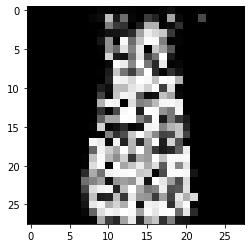

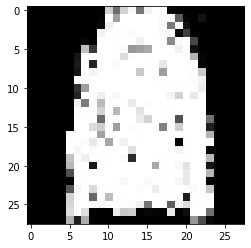

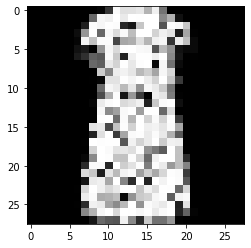

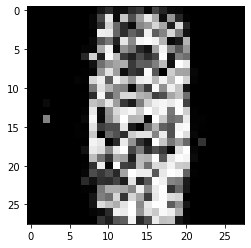

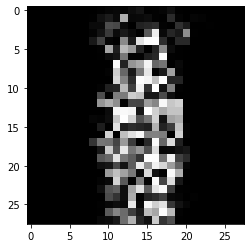

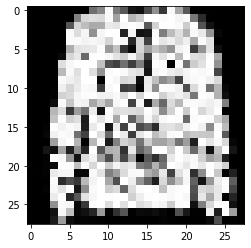

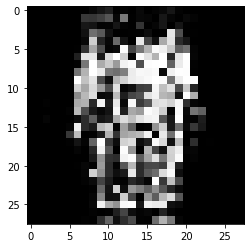

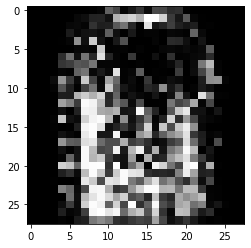

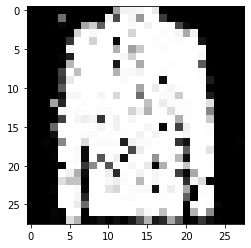

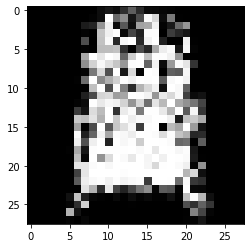

In [111]:
gen_images(generator, n = 10)
# On voit bien que le générateur n'est pas très performant. L'image est toujours bruité, et on voit que le générateur a tendance à toujours sortir les mêmes images, ici le t-shirt. C'est le mode "collapse" mentionné dans le livre

# Ajout du replay dans la boucle d'entrainement

In [10]:
import time

def train_gan_replay(gan, dataset, batch_size, codings_size, batch_memory = 5, n_epochs=50):
    generator, discriminator = gan.layers
    memory = [] # en initialisant ici, la mémoire se porte sur toutes les itérations aussi

    def add_to_memory(memory, batch):
        if len(memory) > 5:
            memory = memory[1:]
        memory.append(batch)

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        start = time.time()
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            X_fake_and_real = [generated_images, X_batch]
            X_fake_and_real = X_fake_and_real + memory
            X_fake_and_real = tf.concat(X_fake_and_real, axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size + [[0.]] * len(memory) * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

            add_to_memory(memory, generated_images)

            if (epoch + 1) % 10 = 0:
                gen_images(gan.layers[0], codings_size = codings_size, n = 5)
        end = time.time()
        print(f"Epoch took {(end - start)}. s")

In [171]:
codings_size = 30
gan_replay = create_simple_gan(codings_size)
train_gan_replay(gan, dataset, batch_size, codings_size, n_epochs=20)


Epoch 1/20


KeyboardInterrupt: 

acc_fake:0.8999999761581421
acc_reel:0.8799999952316284


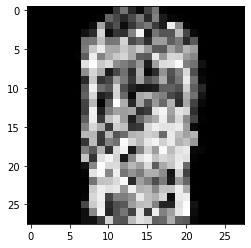

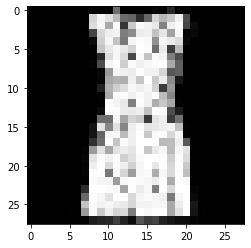

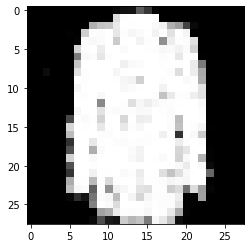

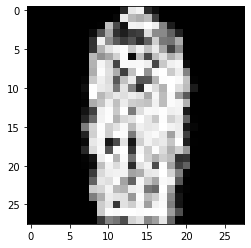

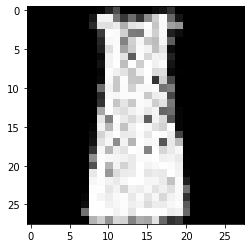

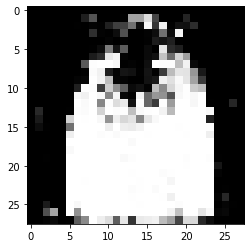

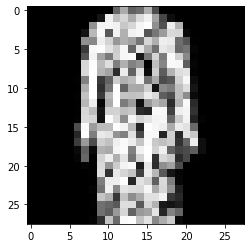

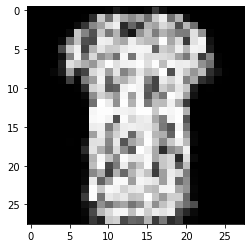

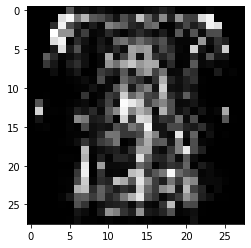

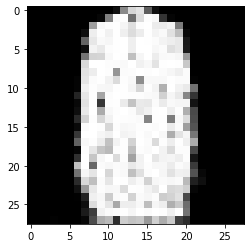

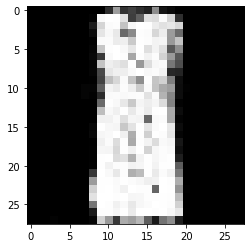

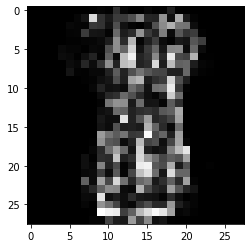

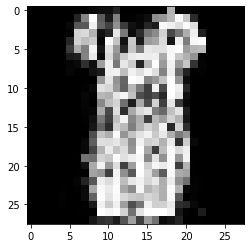

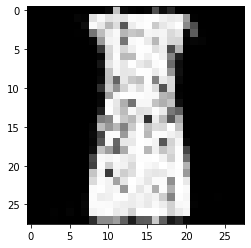

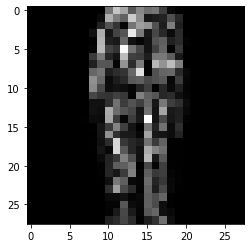

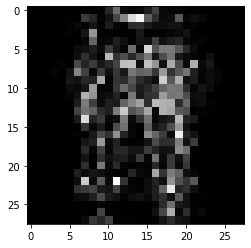

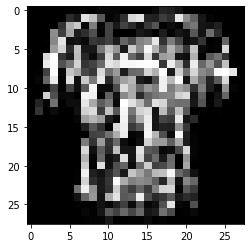

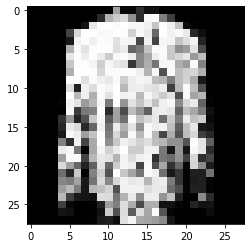

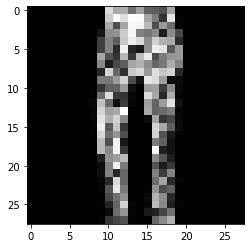

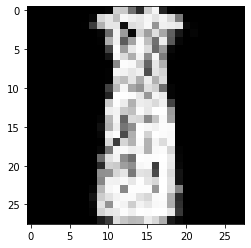

In [149]:
test_discriminator(gan)
gen_images(gan.layers[0], n = 20)

# D'après la valeur de acc_reel, on voit que le discrimineur est plus performant. Il arrive bien à dire qu'une image réelle est bien réelle.
# On voit que le discrimineur arrive fortement à discriminer les images factices. Il se pourrait que le discrimineur soit bien meilleur qu'on ne le pense, ou que le générateur n'est pas à la hauteur.
# D'après les images générés, on voit que le générateur a toujours le soucis de générer des images bruitées (même s'il est un peu meilleur), par contre on voit qu'il a un peu moins ce soucis de vouloir générer uniquement des t-shirt. Même si on voit qu'il ne génère rarement des chaussures. P-ê devrions-nous augmenter la mémoire ?

# Utiliser un GAN profond plutôt qu'un GAN simple

In [188]:
codings_size = 32
# c'est le gan profond du livre
def create_deep_gan(codings_size=100):
    generator = keras.models.Sequential([
        keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
        keras.layers.Reshape([7, 7, 128]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                    activation="selu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                    activation="tanh"),
    ])
    discriminator = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                            activation=keras.layers.LeakyReLU(0.2),
                            input_shape=[28, 28, 1]),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    gan = keras.models.Sequential([generator, discriminator])

    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    discriminator.trainable = False
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return gan, generator, discriminator


dataset_deep = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset_deep = dataset_deep.map(lambda x: tf.reshape(x, x.shape + (1,)))
dataset_deep = dataset_deep.batch(batch_size, drop_remainder=True).prefetch(1)

# disp_dataset(dataset_deep.take(1))


deep_gan, deep_generator, deep_discriminator = create_deep_gan(codings_size)
train_gan_replay(deep_gan, dataset_deep, batch_size, codings_size, n_epochs=20, batch_memory=15)


Epoch 1/20
Epoch took 51.10497260093689. s
Epoch 2/20
Epoch took 50.20316195487976. s
Epoch 3/20
Epoch took 50.8520610332489. s
Epoch 4/20
Epoch took 51.30728006362915. s
Epoch 5/20
Epoch took 51.16704225540161. s
Epoch 6/20
Epoch took 54.49727487564087. s
Epoch 7/20
Epoch took 56.28122591972351. s
Epoch 8/20
Epoch took 56.6442174911499. s
Epoch 9/20
Epoch took 57.253504276275635. s
Epoch 10/20
Epoch took 57.57534623146057. s
Epoch 11/20
Epoch took 57.46847939491272. s
Epoch 12/20
Epoch took 57.7804229259491. s
Epoch 13/20
Epoch took 58.07957148551941. s
Epoch 14/20
Epoch took 57.93685483932495. s
Epoch 15/20
Epoch took 57.90814757347107. s
Epoch 16/20
Epoch took 57.9958918094635. s
Epoch 17/20
Epoch took 58.07066607475281. s
Epoch 18/20
Epoch took 58.42441511154175. s
Epoch 19/20
Epoch took 58.30941438674927. s
Epoch 20/20
Epoch took 58.09696054458618. s


acc_fake:1.0
acc_reel:0.7400000095367432
(10, 32)


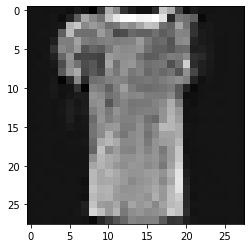

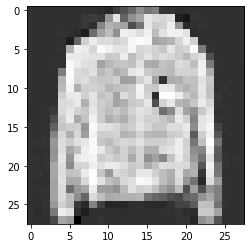

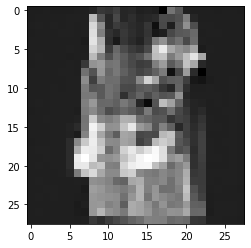

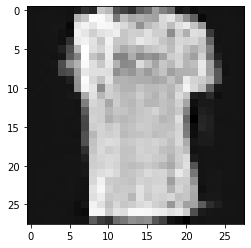

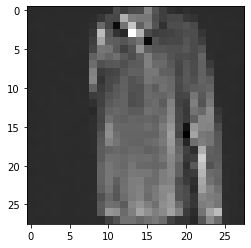

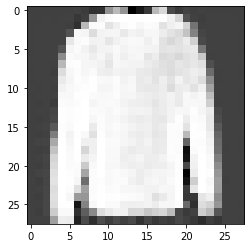

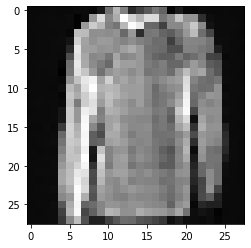

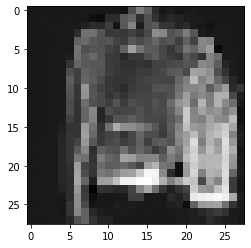

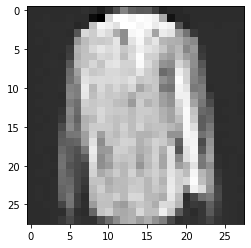

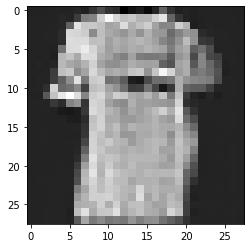

In [201]:
def test_discriminator(gan, test_size=100, reshape=False):
    generator, discriminator = gan.layers
    unit_size = int(test_size / 2)
    noise = tf.random.normal(shape=[unit_size, codings_size])
    X_fake = generator(noise)


    X_reel = tf.constant(X_test[:unit_size, :, :])
    if reshape:
        X_fake = tf.reshape(X_fake, X_fake.shape + (1,))
        X_reel = tf.reshape(X_reel, X_reel.shape + (1,))

    y_fake = tf.constant([[0.]] * unit_size)
    y_reel = tf.constant([[1.]] * unit_size)

    predict_fake = tf.math.round(discriminator(X_fake))
    predict_reel = tf.math.round(discriminator(X_reel))

    acc_fake = accuracy_score(y_fake, predict_fake)
    acc_reel = accuracy_score(y_reel, predict_reel)

    print(f"acc_fake:{acc_fake}")
    print(f"acc_reel:{acc_reel}")

def gen_images(model, codings_size=32, n=5, reshape=False):
    noises = tf.random.normal([n, codings_size])
    print(noises.shape)
    generated = model(noises)
    if reshape:
        generated = tf.reshape(generated, generated.shape[:-1])
    generated = generated.numpy()
    show_image(generated)
    

test_discriminator(deep_gan, reshape=True)
gen_images(deep_gan.layers[0], codings_size=32, n = 10, reshape=True)
# Le discrimineur arrive parfaitement à discriminer les images du générateur, mais il n'arrive pas à bien dire si une image réelle l'est ou non. 
# 1. Le générateur est très mauvais, et le discrimineur est moyen mais reste sur-ajusté au générateur
# 2. Ou alors le générateur est bon, il arrive à produire des images proches du réel, et quand on présente une image réelle au discrimineur, il ne sait pas trop si cela vient du générateur ou non, mais le discrimineur arrive quand même à discerner ceux du générateurs (ce qui est un peu illogique ?)

# On voit qu'on a à nouveau notre problème de collapse, le générateur ne se met qu'à générer des T-shirt. Pourtant, nous avons mis une batch_memory bien plus importante. A quoi cela est-il dû ?

In [161]:
test = tf.constant([[[1],[2]], [[1],[2]]])
tf.reshape(test, test.shape[:-1])

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [1, 2]], dtype=int32)>

# Trying to generate Pokemon

Longueur de pokemon_list:2457
Nbr de channel: 3


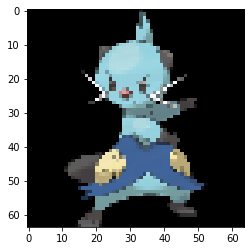

In [2]:
import os

path = "./pokemon/pokemon/"
count = 0
resize = 64

def load_pokemon_list():
    pokemon_list = [] # array of 2D arrays
    for img_path in os.listdir(path):
        # if count > 10:
            # break
        img = plt.imread(os.path.join(path, img_path))
        # Les images ont déjà les valeurs entre 0 et 1
        # Il y a 4 canaux, on ne garde que les 3 premiers qui sont les couleurs
        # l'image étant trop grande, on resize pour prendre moins de mémoire
        img = tf.constant(img)
        img = tf.image.resize(img, [resize, resize])
        img = img[:,:,:3]
        pokemon_list.append(img)
        # count += 1
    return pokemon_list

def augment_data(img_list, shift_size = 10):
    new_list = []
    for img in img_list:
        color_shift = 0.5
        horizontal_shift = 0.1
        img1 = tf.keras.preprocessing.image.random_shift(img, color_shift, horizontal_shift)
        img2 = tf.keras.preprocessing.image.random_shift(img, color_shift, horizontal_shift)
        new_list.append(img)
        new_list.append(img1)
        new_list.append(img2)

        # new_list.append(tf.roll(img, shift_size, 0))
        # new_list.append(tf.roll(img, shift_size, 1))
        # new_list.append(tf.roll(img, -shift_size, 0))
        # new_list.append(tf.roll(img, -shift_size, 1))
    return new_list

pokemon_list = load_pokemon_list()
channel_size = pokemon_list[0].shape[-1]
pokemon_list = augment_data(pokemon_list)
print(f"Longueur de pokemon_list:{len(pokemon_list)}")
print(f"Nbr de channel: {channel_size}")
plt.imshow(pokemon_list[0])

In [3]:
def augment_img(img, color_shift=0.5, horizontal_shift=0.2):
        img1 = tf.keras.preprocessing.image.random_shift(img, color_shift, horizontal_shift)
        img2 = tf.keras.preprocessing.image.random_shift(img, color_shift, horizontal_shift)
        # La fonction a besoin de retourner un dataset pour faire un flat_map après
        return tf.data.Dataset.from_tensor_slices([img, img, img])

dataset = tf.data.Dataset.from_tensor_slices(pokemon_list)
# dataset = dataset.flat_map(augment_img)
dataset = dataset.shuffle(3000)
X_valid = dataset.take(200).batch(32, drop_remainder=True).prefetch(1)
X_train = dataset.skip(200).batch(32, drop_remainder=True).prefetch(1)

disp_dataset(X_train.take(1))
# plt.imshow(tf.keras.preprocessing.image.random_shift(pokemon_list[0], 0.5, 0.2))


tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [4]:
def show_image(images):
    for img in images:
        plt.figure()
        plt.imshow(img)

def test_discriminator(gan, test_size=100, reshape=False):
    generator, discriminator = gan.layers
    unit_size = int(test_size / 2)
    noise = tf.random.normal(shape=[unit_size, codings_size])
    X_fake = generator(noise)


    X_reel = tf.constant(X_test[:unit_size, :, :])
    if reshape:
        X_fake = tf.reshape(X_fake, X_fake.shape + (1,))
        X_reel = tf.reshape(X_reel, X_reel.shape + (1,))

    y_fake = tf.constant([[0.]] * unit_size)
    y_reel = tf.constant([[1.]] * unit_size)

    predict_fake = tf.math.round(discriminator(X_fake))
    predict_reel = tf.math.round(discriminator(X_reel))

    acc_fake = accuracy_score(y_fake, predict_fake)
    acc_reel = accuracy_score(y_reel, predict_reel)

    print(f"acc_fake:{acc_fake}")
    print(f"acc_reel:{acc_reel}")

def gen_images(model, codings_size=32, n=5, reshape=False):
    noises = tf.random.normal([n, codings_size])
    generated = model(noises)
    if reshape:
        generated = tf.reshape(generated, generated.shape[:-1])
    generated = generated.numpy()
    show_image(generated)

import time

# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root, "tsboard", run_id)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50, run_name=None, dir_name=None):
    generator, discriminator = gan.layers

    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") if run_name is None else run_name
    dir_id = "ian_good_fellow_loss" if dir_name is None else dir_name
    tsboard_gen = keras.callbacks.TensorBoard(f"./pokemon/tsboard/{dir_id}/gen/{run_id}", update_freq="epoch")
    tsboard_disc = keras.callbacks.TensorBoard(f"./pokemon/tsboard/{dir_id}/disc/{run_id}", update_freq="epoch")

    tsboard_disc.set_model(discriminator)
    tsboard_gen.set_model(gan) # Le générateur est entrainé à travers le gan

    def named_logs(model, logs):
        result = {}
        for l in zip(model.metrics_names, logs):
            result[l[0]] = l[1]
        return result


    losses_disc_global = []
    losses_gen_global = []
    accuracies_disc_global = []
    accuracies_gen_global = []
    for epoch in range(n_epochs):
        losses_disc = []
        losses_gen = []
        accuracies_disc = []
        accuracies_gen = []
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        start = time.time()
        for X_batch in dataset:

            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            loss, acc = discriminator.train_on_batch(X_fake_and_real, y1)
            losses_disc.append(loss)
            accuracies_disc.append(acc)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            loss, acc = gan.train_on_batch(noise, y2)
            losses_gen.append(loss)
            accuracies_gen.append(acc)

        end = time.time()
        losses_disc_global.append(np.mean(losses_disc))
        accuracies_disc_global.append(np.mean(accuracies_disc))
        losses_gen_global.append(np.mean(losses_gen))
        accuracies_gen_global.append(np.mean(accuracies_gen))

        tsboard_disc.on_epoch_end(epoch, named_logs(discriminator, [losses_disc_global[-1], accuracies_disc_global[-1]]))
        tsboard_gen.on_epoch_end(epoch, named_logs(gan, [losses_gen_global[-1], accuracies_gen_global[-1]]))

        print(f"Epoch took {(end - start)}. s")
        print(f"Discriminator loss:{losses_disc_global[-1]} | accuracy: {accuracies_disc_global[-1]}")
        print(f"Generator loss:{losses_gen_global[-1]} | accuracy: {accuracies_gen_global[-1]}")

    tsboard_disc.on_train_end(None)
    tsboard_gen.on_train_end(None)
    return losses_disc_global, accuracies_disc_global, losses_gen_global, accuracies_gen_global

def plot_losses_from_train_gan(losses_disc_global, accuracies_disc_global, losses_gen_global, accuracies_gen_global):
    x = [i + 1 for i in range(len(losses_disc_global))]
    plt.figure()
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(x, losses_disc_global, label="discriminator")
    plt.plot(x, losses_gen_global, label="generator")
    plt.legend()
    plt.subplot("122")
    plt.title("Accuracy")
    plt.plot(x, accuracies_disc_global, label="discriminator")
    plt.plot(x, accuracies_gen_global, label="generator")
    plt.legend()
    plt.show()


In [5]:
codings_size = 100
batch_size = 32

def create_deep_gan(codings_size=100, img_size=resize, lr=0.0002):
    # generator = keras.models.Sequential([
    #     keras.layers.Dense(8 * 8 * 128, input_shape=[codings_size]),
    #     keras.layers.Reshape([8, 8, 128]),
    #     keras.layers.BatchNormalization(momentum=0.5),
    #     keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
    #                                 activation="selu"),
    #     keras.layers.BatchNormalization(momentum=0.5),
    #     keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="SAME",
    #                         activation="selu"),
    #     keras.layers.BatchNormalization(momentum=0.5),
    #     keras.layers.Conv2DTranspose(channel_size, kernel_size=5, strides=2, padding="SAME",
    #                                 activation="sigmoid"),
    # ])
    # discriminator = keras.models.Sequential([
    #     keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
    #                         activation=keras.layers.LeakyReLU(0.2),
    #                         input_shape=[img_size, img_size, 3]),
    #     keras.layers.Dropout(0.4),
    #     keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
    #                         activation=keras.layers.LeakyReLU(0.2)),
    #     keras.layers.Dropout(0.4),
    #     keras.layers.Flatten(),
    #     keras.layers.Dense(1, activation="sigmoid")
    # ])

    
    # https://github.com/ghanashyamvtatti/PokeGAN/blob/master/GAN.py
    generator = keras.models.Sequential([
        keras.layers.Dense(4 * 4 * 512, input_shape=[codings_size],                                                     kernel_initializer='glorot_uniform'),
        keras.layers.Reshape([4, 4, 512]),
        keras.layers.BatchNormalization(momentum=0.5),
        keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="SAME",
                                    kernel_initializer='glorot_uniform',
                                    activation="relu"),
        keras.layers.BatchNormalization(momentum=0.5),
        keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",
                                    kernel_initializer='glorot_uniform',
                            activation="relu"),
        keras.layers.BatchNormalization(momentum=0.5),
        keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                    kernel_initializer='glorot_uniform',
                            activation="relu"),
        keras.layers.BatchNormalization(momentum=0.5),
        keras.layers.Conv2DTranspose(channel_size, kernel_size=5, strides=2, padding="SAME",
                                kernel_initializer='glorot_uniform',
                                    activation="sigmoid"),
    ])
    discriminator = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                            activation=keras.layers.LeakyReLU(0.2),
                            kernel_initializer='glorot_uniform',
                            input_shape=[img_size, img_size, 3]),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                            kernel_initializer='glorot_uniform',
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",
                            kernel_initializer='glorot_uniform',
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="SAME",
                            kernel_initializer='glorot_uniform',
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.BatchNormalization(momentum=0.5),
        keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid")
    ])


    gan = keras.models.Sequential([generator, discriminator])
    optimizer = tf.optimizers.Adam(lr=lr, beta_1=0.5)
    # optimizer="rmsprop"

    # checkpoints = keras.callbacks.ModelCheckpoint("my_pmc_model.h5", save_best_only=True)
    # early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    discriminator.trainable = False
    gan.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return gan, generator, discriminator

# lr = 2e-4
# deep_gan, deep_generator, deep_discriminator = create_deep_gan(codings_size, lr=lr)
# # deep_gan.load_weights('./pokemon/weights/deep_gan_weights.h5')
# loss_disc, acc_disc, loss_gen, acc_gen = train_gan(deep_gan, X_train, batch_size, codings_size, n_epochs=10, run_name=f"lr={lr}")
# plot_losses_from_train_gan(loss_disc, acc_disc, loss_gen, acc_gen)

for lr in [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4]:
    deep_gan, deep_generator, deep_discriminator = create_deep_gan(codings_size, lr=lr)
# deep_gan.load_weights('./pokemon/weights/deep_gan_weights.h5')
    loss_disc, acc_disc, loss_gen, acc_gen = train_gan(deep_gan, X_train, batch_size, codings_size, n_epochs=10, run_name=f"lr={lr}")
    plot_losses_from_train_gan(loss_disc, acc_disc, loss_gen, acc_gen)

Epoch 1/10


KeyboardInterrupt: 

Epoch 1/10
Epoch took 11.910843133926392. s
Discriminator loss:0.11328355602547246 | accuracy: 0.9662946428571428
Generator loss:18.786149896894184 | accuracy: 0.007589285714285714
Epoch 2/10
Epoch took 10.807618856430054. s
Discriminator loss:0.11405065521664386 | accuracy: 0.9709821428571429
Generator loss:9.911443998132434 | accuracy: 0.065625
Epoch 3/10
Epoch took 10.292333602905273. s
Discriminator loss:0.0949257627395647 | accuracy: 0.9723214285714286
Generator loss:10.441503836427415 | accuracy: 0.06205357142857143
Epoch 4/10
Epoch took 10.805008888244629. s
Discriminator loss:0.08957315120496787 | accuracy: 0.971875
Generator loss:10.837675503322057 | accuracy: 0.09151785714285714
Epoch 5/10
Epoch took 10.49073076248169. s
Discriminator loss:0.13689184326545467 | accuracy: 0.9506696428571428
Generator loss:10.43909135886601 | accuracy: 0.08392857142857142
Epoch 6/10
Epoch took 10.209313154220581. s
Discriminator loss:0.1001548004270132 | accuracy: 0.965625
Generator loss:8.0505

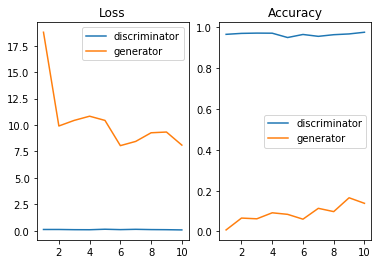

In [24]:
# train_gan_replay(deep_gan, X_train, batch_size, codings_size, n_epochs=50, batch_memory=15)
loss_disc, acc_disc, loss_gen, acc_gen = train_gan(deep_gan, X_train, batch_size, codings_size, n_epochs=10, run_name="lr=0.0002")
plot_losses_from_train_gan(loss_disc, acc_disc, loss_gen, acc_gen)

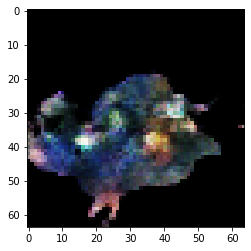

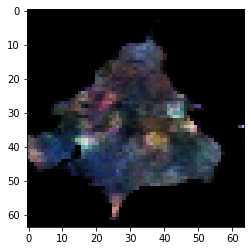

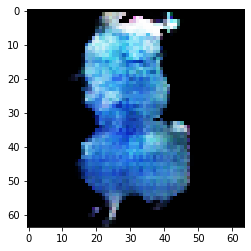

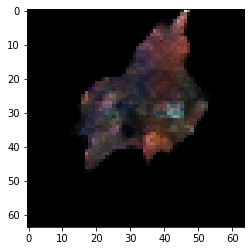

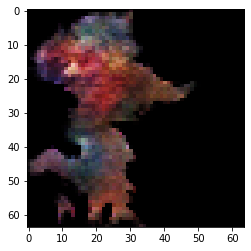

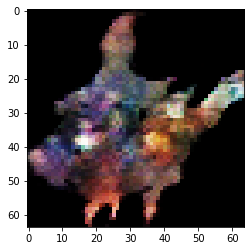

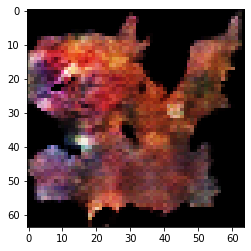

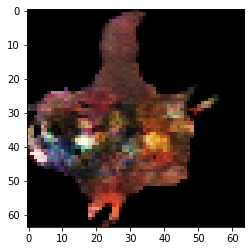

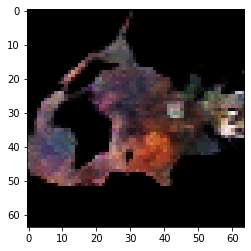

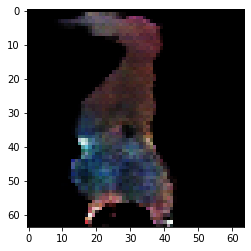

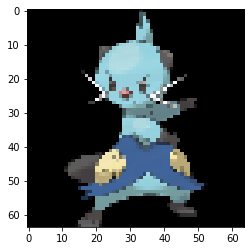

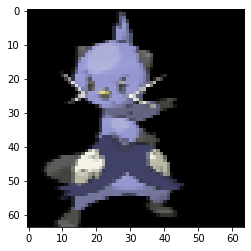

In [21]:

# test_discriminator(deep_gan)
gen_images(deep_gan.layers[0], codings_size = codings_size, n = 10)
show_image(pokemon_list[:2])
# deep_gan.save_weights('./pokemon/weights/deep_gan_weights.h5')


# Explication de la difficulté de l'entrainement avec la loss minmax habituelle de GoodFellow

https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

- Si on considère 2 distribution de proba p et q très différentes, par ex gaussiennes de moyennes très différentes: la divergence de KL et la divergence de JS commencent à tendre vers un palier. Càd que vers ce palier, le gradient par rapport à la distribution q est quasi-nulle. 
- Optimiser un GAN avec les loss originales de GoodFellow, quand le discrimineur devient presque parfait, revient à minimiser la loss de JS pour ce GAN (rappel que la loss du générateur et la loss finale du gan), et de ce fait, le gradient est quasi-nul, comme vu au point précédent
- Intuitivement, on comprend que si le discrimineur devient parfait, alors la loss du générateur log(1-D(G(z))) dont le gradient : u'/u  vaudra Grad(D(G(z))) / (1 - D(G(z))) ? tendra vers 0
- Si on utilise le D-trick càd une loss -log(D(G(z))), alors le gradient:  Grad(D(G(z))) / D_G_z = ~0/0, on peut comprendre alors qu'il y a instabilité car division par 0

https://arxiv.org/pdf/1701.04862.pdf, papier de Arjovsky, montre que si 2 distributions p et q ont de supports disjoints (càd sont très différents) ou qu'ils se trouvent dans des variétés à faibles dimensions ?, alors pour un générateur fixé, il existe un discrimineur parfait D* qui a toujours raison.  Autrement dit, on voit un discrimineur parfait apparaitre très rapidement lors de l'entrainement
- Son Theorem 2.4 (Vanishing gradients on the generator), montre que au fur et à mesure que le discrimineur D se rapproche de l'optimal D*, la norme des gradients de la loss originale du Générateur (sans le D-trick) diminue (pblm de disparition des gradients)
- Concernant le D-trick, il montre que le gradient de la nouvelle loss du générateur "is a centered Cauchy distribution with infinite expectation and variance". Au fur et à mesure et à mesure que D se rapproche de D*, la norme des gradients et la variance, augmente aussi, menant à un entrainement très instable
- Il propose d'ajouter du bruit aux entrées du discrimineur pour stabiliser le modèle, par ex gaussien d'ecart-type 0.1 ou 0.01

https://arxiv.org/pdf/1701.07875.pdf, papier de Arjovsky, propose d'utiliser la loss de Wasserstein, car elle a des gradients plus lisses, moins prône à la disparition des gradients, et permet à une distribution de tendre vers une autre par loi

# Essaie avec la loss de Wasserstein
- https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490 pour une lecture compréhensive

- Pour le discrimineur, on remplace la dernière couche sigmoïde par une couche Dense(1) normale. On ne cherche plus la probabilité binaire d'appartenance à une image réelle ou non, mais on chercher à approcher une mesure de distance entre 2 proba, qui est la mesure de Wasserstein
- Dans le papier Wasserstein GAN https://arxiv.org/pdf/1701.07875.pdf, ils proposent d'utiliser un gradient_clip c=0.01, afin de s'assurer que le discrimineur approche une fonction lipzschitzienne, mais il semblerait que ça, combiné avec l'utilisation de batch_normalization rend la convergence du discrimineur difficile
- Dans https://papers.nips.cc/paper/2017/file/892c3b1c6dccd52936e27cbd0ff683d6-Paper.pdf, ils proposent d'utiliser LayerNormalization au lieu de BatchNormalization, et au lieu d'utiliser un gradient_clip, d'utiliser une perte pénalisée reposant sur les gradients
- https://arxiv.org/pdf/1701.07875.pdf montre qu'on peut avoir la 1-lipzschitzienne, ssi la fonction f a des gradients de norme 1 presque partout. On ajoute donc une pénalité de poru les gradients pour qu'ils ne diffèrent pas trop de la norme 1, et on ajoute ça à la loss
- On ajoute aussi un peu de bruit gaussien à l'entrée du discrimineur, dans le but d'adoucir la distribution de proba des images d'entrées


- Quelle métrique utiliser pour mesurer la performance de notre GAN ? Le discrimineur renvoie une valeur indiquant à quel point une image est bien réelle.
- Pour un WGAN optimal, le générateur doit avoir une loss très faible, car le discrimineur doit penser que c'est une image réelle (et donc lui donne une grande mesure). On rappelle que la loss du générateur est - D(G(z))
- Quand au discrimineur, ce dernier doit avoir une loss qui au bout d'un moment devra converger vers 0 ? Car si on suppose que le générateur est devenu optimal, alors le discrimineur ne devrait plus pouvoir faire la différence, et donc sa loss étant -(D_x - D_G_z), on devrait tendre vers 0
- -D(G(z)) est la loss du générateur. Puisque le WGAN cherche à minimiser -D(G(z)), on pourrait dire que sa faible valeur est aussi indicatrice que l'estimation de Wasserstein (D_x - D_G_z) tends vers 0

https://arxiv.org/pdf/1701.07875.pdf, a montré que la loss du discrimineur (qui estime la distance de Wasserstein), est une bonne métrique qui mesure la qualité de l'image (alors qu'avant, aucun gan n'avait de réelle corrélation entre qualité de l'image et loss). On pourraît aussi utiliser la loss du générateur ?

- Ils ont aussi montré que le WGAN était moins prône au mode collapse,
- et qu'il était possible d'entrainer le générateur, même quand le discrimineur était très bon (d'ailleurs il est encouragé de l'optimiser plusieurs fois pour 1 tour de générateur), car il donnera une meilleur estimation de la mesure de Wasserstein


# CONCLUSION
- On peut conclure que WGAN permet d'avoir un entrainement plus stable, empêchant la disparition ou l'instabilité des gradients, ou le discrimineur peut être entrainé à l'optimum, et permet d'avoir une métrique corrélée avec la qualité des images produites

In [1]:
codings_size = 100
batch_size = 32

class WassersteinLossDiscriminator(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, y_true, y_pred): # y_true = D_x, y_pred = D_g_z
        # https://developers.google.com/machine-learning/gan/loss
        to_maximize = y_true - y_pred
        # to_maximize = tf.reduce_mean(y_true - y_pred)
        return 0 - to_maximize # because we want to minimize the loss
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

class WassersteinLossGenerator(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, y_true, y_pred): # y_true = D_x, y_pred = D_g_z
    # https://developers.google.com/machine-learning/gan/loss
        to_maximize = y_pred
        # to_maximize = tf.reduce_mean(y_pred)
        return 0 - to_maximize # because we want to minimize the loss
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

def create_generator_wass(codings_size=100):
    model = keras.models.Sequential([
        keras.layers.Dense(4 * 4 * 512, input_shape=[codings_size],                                                   kernel_initializer='glorot_uniform'),
        keras.layers.Reshape([4, 4, 512]),
        # https://papers.nips.cc/paper/2017/file/892c3b1c6dccd52936e27cbd0ff683d6-Paper.pdf 
        # advices to use LayerNormalisation instead of BatchNormalization
        keras.layers.LayerNormalization(), 
        keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="SAME",
                                    kernel_initializer='glorot_uniform',
                                    activation="relu"),
        keras.layers.LayerNormalization(),
        keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",
                                    kernel_initializer='glorot_uniform',
                            activation="relu"),
        keras.layers.LayerNormalization(),
        keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                    kernel_initializer='glorot_uniform',
                            activation="relu"),
        keras.layers.LayerNormalization(),
        keras.layers.Conv2DTranspose(channel_size, kernel_size=5, strides=2, padding="SAME",
                                kernel_initializer='glorot_uniform',
                                    activation="sigmoid"),
    ])
    return model

def create_discriminator_wass(img_size):
    discriminator = keras.models.Sequential([
        # keras.layers.GaussianNoise(0.1, input_shape=[img_size, img_size, 3]),
        keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                            activation=keras.layers.LeakyReLU(0.2),
                            kernel_initializer='glorot_uniform',
                            input_shape=[img_size, img_size, 3]
                            ),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                            kernel_initializer='glorot_uniform',
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",
                            kernel_initializer='glorot_uniform',
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="SAME",
                            kernel_initializer='glorot_uniform',
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.BatchNormalization(momentum=0.5),
        # keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1)
    ])
    return discriminator

def create_deep_gan_wasserstein(codings_size=100, img_size=resize, lr=0.0002):    
    # https://github.com/ghanashyamvtatti/PokeGAN/blob/master/GAN.py
    generator = create_generator_wass(codings_size)
    discriminator = create_discriminator_wass(img_size)


    gan = keras.models.Sequential([generator, discriminator])
    optimizer = keras.optimizers.RMSprop(lr=0.001, clipvalue=0.01)
    optimizer2 = keras.optimizers.RMSprop(lr=0.001)
    # optimizer="rmsprop"

    # checkpoints = keras.callbacks.ModelCheckpoint("my_pmc_model.h5", save_best_only=True)
    # early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

    discriminator.compile(loss=WassersteinLossDiscriminator(), optimizer=optimizer, metrics=["accuracy"]) #accuracy does not mean anything anymore here
    discriminator.trainable = False
    gan.compile(loss=WassersteinLossGenerator(), optimizer=optimizer2, metrics=["accuracy"])
    
    return gan, generator, discriminator

#https://keras.io/examples/generative/wgan_gp/
class WGAN(tf.keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        batch_size=32
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.batch_size = batch_size
        self.best_metric = -1e20

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, save_weights_path):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.save_weights_path = save_weights_path

    def update_metric(self, new_metric):
        if new_metric > self.best_metric:
            self.best_metric = new_metric
            self.save_weights(save_weights_path)

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = self.batch_size

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True) # c'est plutôt la mesure de distance que logits
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(y_true=real_logits, y_pred=fake_logits)
                d_loss = d_cost
                if self.gp_weight is not None:
                    # Calculate the gradient penalty
                    gp = self.gradient_penalty(batch_size, real_images, fake_images)
                    # Add the gradient penalty to the original discriminator loss
                    d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(y_true=None, y_pred=gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        # self.update_metric(-g_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}

NameError: name 'keras' is not defined

In [7]:
def get_tsboard_dir(dir_id, run_id):
    return [f"./pokemon/tsboard/{dir_id}/{model}/{run_id}" for model in ("gen", "disc")]

def get_tsboard_cb(dir_id, run_id):
    dir1, dir2 = get_tsboard_dir(dir_id, run_id)
    return [keras.callbacks.TensorBoard(d, update_freq="epoch") for d in (dir1, dir2)]

def train_gan_wass(gan, dataset, batch_size, codings_size, n_epochs=50, run_name=None, dir_name=None):
    generator, discriminator = gan.layers

    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") if run_name is None else run_name
    dir_id = "ian_good_fellow_loss" if dir_name is None else dir_name
    tsboard_gen = keras.callbacks.TensorBoard(f"./pokemon/tsboard/{dir_id}/gen/{run_id}", update_freq="epoch")
    tsboard_disc = keras.callbacks.TensorBoard(f"./pokemon/tsboard/{dir_id}/disc/{run_id}", update_freq="epoch")

    tsboard_disc.set_model(discriminator)
    tsboard_gen.set_model(gan) # Le générateur est entrainé à travers le gan

    def named_logs(model, logs):
        result = {}
        for l in zip(model.metrics_names, logs):
            result[l[0]] = l[1]
        return result


    losses_disc_global = []
    losses_gen_global = []
    accuracies_disc_global = []
    accuracies_gen_global = []
    for epoch in range(n_epochs):
        losses_disc = []
        losses_gen = []
        accuracies_disc = []
        accuracies_gen = []
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        start = time.time()
        for X_batch in dataset:
            # On entraine le discrimineur plusieurs fois pour un même tour de générateur
            losses_k = []
            accuracy_k = []
            for k in range(10):
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                generated_images = generator(noise)

                G_z = generated_images
                D_x = tf.constant(discriminator(X_batch))

                discriminator.trainable = True
                loss, acc = discriminator.train_on_batch(G_z, D_x)

                losses_k.append(loss)
                accuracy_k.append(acc)

            # losses_disc.append(loss)
            # accuracies_disc.append(acc)
            losses_disc.append(tf.reduce_mean(losses_k))
            accuracies_disc.append(tf.reduce_mean(accuracy_k))

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            discriminator.trainable = False
            loss, acc = gan.train_on_batch(noise, y=tf.constant([0.] * batch_size)) # y is not used anyway
            # y = None does not work : error no gradient provided
            losses_gen.append(loss)
            accuracies_gen.append(acc)

        end = time.time()
        losses_disc_global.append(np.mean(losses_disc))
        accuracies_disc_global.append(np.mean(accuracies_disc))
        losses_gen_global.append(np.mean(losses_gen))
        accuracies_gen_global.append(np.mean(accuracies_gen))

        tsboard_disc.on_epoch_end(epoch, named_logs(discriminator, [losses_disc_global[-1], accuracies_disc_global[-1]]))
        tsboard_gen.on_epoch_end(epoch, named_logs(gan, [losses_gen_global[-1], accuracies_gen_global[-1]]))

        print(f"Epoch took {(end - start)}. s")
        print(f"Discriminator loss:{losses_disc_global[-1]} | accuracy: {accuracies_disc_global[-1]}")
        print(f"Generator loss:{losses_gen_global[-1]} | accuracy: {accuracies_gen_global[-1]}")

    tsboard_disc.on_train_end(None)
    tsboard_gen.on_train_end(None)
    return losses_disc_global, accuracies_disc_global, losses_gen_global, accuracies_gen_global


Epoch 1/10
Epoch took 50.85354423522949. s
Discriminator loss:-28.72562026977539 | accuracy: 0.0
Generator loss:4524.077609906878 | accuracy: 1.0
Epoch 2/10
Epoch took 49.02983474731445. s
Discriminator loss:21.238229751586914 | accuracy: 0.0
Generator loss:19311.88564453125 | accuracy: 1.0
Epoch 3/10
Epoch took 49.12587547302246. s
Discriminator loss:73.03456115722656 | accuracy: 0.0
Generator loss:42968.6564453125 | accuracy: 1.0
Epoch 4/10
Epoch took 50.02780818939209. s
Discriminator loss:349.8894348144531 | accuracy: 0.0
Generator loss:75560.34665178572 | accuracy: 1.0
Epoch 5/10
Epoch took 48.89559197425842. s
Discriminator loss:479.69866943359375 | accuracy: 0.0
Generator loss:117288.56183035714 | accuracy: 1.0
Epoch 6/10
Epoch took 49.044522762298584. s
Discriminator loss:556.6649169921875 | accuracy: 0.0
Generator loss:167531.7064732143 | accuracy: 1.0
Epoch 7/10
Epoch took 48.70461130142212. s
Discriminator loss:614.8910522460938 | accuracy: 0.0
Generator loss:227019.27946428

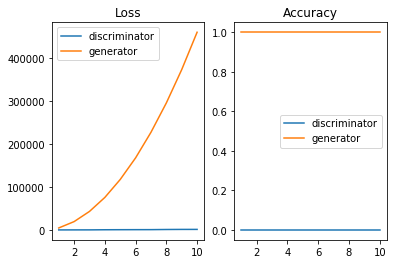

In [133]:
    wass_gan,_,_ = create_deep_gan_wasserstein()
    loss_disc, acc_disc, loss_gen, acc_gen = train_gan_wass(wass_gan, X_train, batch_size, codings_size, n_epochs=10,dir_name="wasserstein_loss", run_name=f"lr=rmsprop")
    plot_losses_from_train_gan(loss_disc, acc_disc, loss_gen, acc_gen)

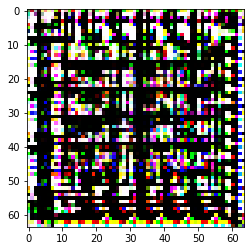

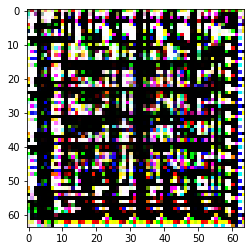

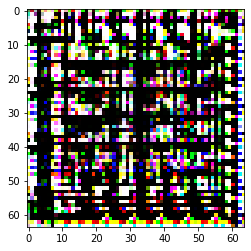

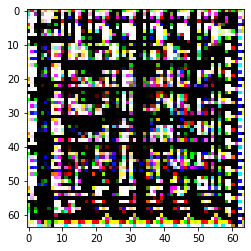

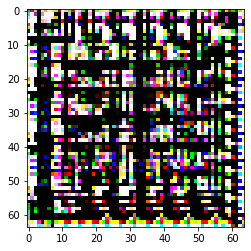

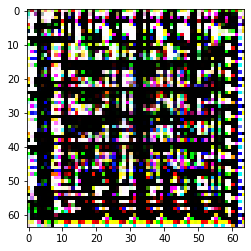

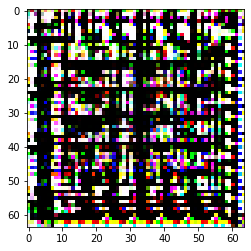

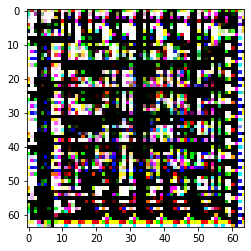

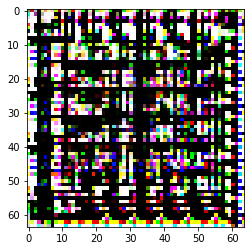

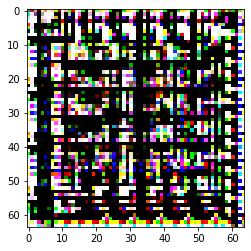

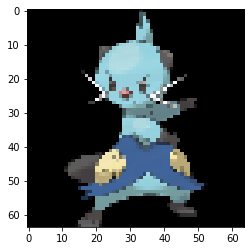

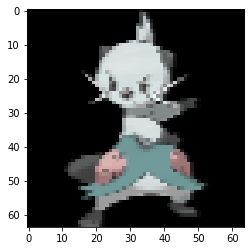

In [58]:
gen_images(wass_gan.layers[0], codings_size = codings_size, n = 10)
show_image(pokemon_list[:2])

Epoch 1/100
70/70 [==============================] - 40s 470ms/step - d_loss: -169.8426 - g_loss: 33.9585
Epoch 2/100
70/70 [==============================] - 33s 472ms/step - d_loss: -302.0502 - g_loss: 2.7523
Epoch 3/100
70/70 [==============================] - 35s 495ms/step - d_loss: -564.8259 - g_loss: -23.1012
Epoch 4/100
70/70 [==============================] - 38s 539ms/step - d_loss: -986.2931 - g_loss: 299.3401
Epoch 5/100
70/70 [==============================] - 36s 521ms/step - d_loss: -1816.0392 - g_loss: 529.9114
Epoch 6/100
70/70 [==============================] - 34s 482ms/step - d_loss: -2821.9995 - g_loss: 939.0364
Epoch 7/100
70/70 [==============================] - 33s 469ms/step - d_loss: -4131.7208 - g_loss: 1547.0956
Epoch 8/100
70/70 [==============================] - 33s 469ms/step - d_loss: -5881.5645 - g_loss: 2840.1270
Epoch 9/100
70/70 [==============================] - 34s 486ms/step - d_loss: -7707.9076 - g_loss: 3853.6949
Epoch 10/100
70/70 [============

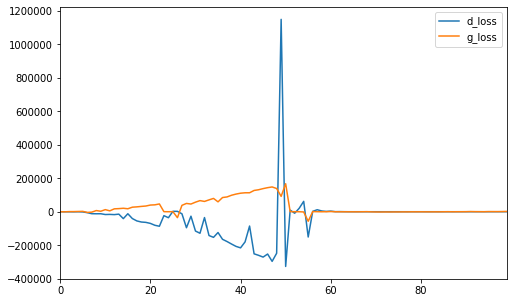

In [37]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

from pathlib import Path
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, lr=0.001,n_100=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_100 = n_100

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            directory = f"./pokemon/img_generated/wgan_gp/lr_{lr}/{self.n_100}"
            Path(directory).mkdir(parents=True, exist_ok=True)
            img.save(f"{directory}/generated_epoch_{epoch}_img_{i}.png".format(i=i, epoch=epoch))

discriminator = create_discriminator_wass(resize)
generator = create_generator_wass(codings_size)
wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=codings_size,
    discriminator_extra_steps=3,
    batch_size=batch_size,
    gp_weight=10.0
)


lr = 0.001
optimizer_discriminator = keras.optimizers.RMSprop(lr=lr)
optimizer_generator = keras.optimizers.RMSprop(lr=lr)
save_weights_path = f"./pokemon/weights/wgan_gp/wgan_gp_weights_lr_{lr}.h5"
wgan.compile(
    d_optimizer=optimizer_discriminator,
    g_optimizer=optimizer_generator,
    g_loss_fn=WassersteinLossGenerator(),
    d_loss_fn=WassersteinLossDiscriminator(),
    save_weights_path=save_weights_path
)

# wgan.load_weights(save_weights_path)
n_100 = 1
cbk = GANMonitor(num_img=3, latent_dim=codings_size, lr=lr)
tsboard = keras.callbacks.TensorBoard(f"./pokemon/tsboard/wass_gp/lr={lr}/n_100_{n_100}")

history = wgan.fit(X_train, batch_size=batch_size, epochs=100, callbacks=[cbk,tsboard])
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))


Epoch 1/100
70/70 [==============================] - 36s 507ms/step - d_loss: -31.7125 - g_loss: 1516.0326
Epoch 2/100
70/70 [==============================] - 35s 498ms/step - d_loss: -44.3296 - g_loss: 376.9892
Epoch 3/100
70/70 [==============================] - 34s 492ms/step - d_loss: -32.0719 - g_loss: -636.9485
Epoch 4/100
70/70 [==============================] - 34s 478ms/step - d_loss: -35.8541 - g_loss: -387.6849
Epoch 5/100
70/70 [==============================] - 35s 499ms/step - d_loss: -53.4850 - g_loss: -80.1293
Epoch 6/100
70/70 [==============================] - 38s 543ms/step - d_loss: -65.3465 - g_loss: 98.0637
Epoch 7/100
70/70 [==============================] - 38s 545ms/step - d_loss: -73.4365 - g_loss: 899.9198
Epoch 8/100
70/70 [==============================] - 38s 548ms/step - d_loss: -79.4865 - g_loss: 1026.5753
Epoch 9/100
70/70 [==============================] - 38s 548ms/step - d_loss: -148.9090 - g_loss: 1707.9924
Epoch 10/100
70/70 [=====================

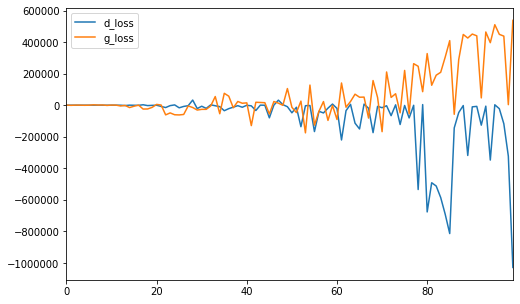

In [43]:
n_100 = n_100 + 1
cbk = GANMonitor(num_img=3, latent_dim=codings_size, lr=lr)
tsboard = keras.callbacks.TensorBoard(f"./pokemon/tsboard/wass_gp/lr={lr}/n_100_{n_100}")

history = wgan.fit(X_train, batch_size=batch_size, epochs=100, callbacks=[cbk, tsboard])
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))

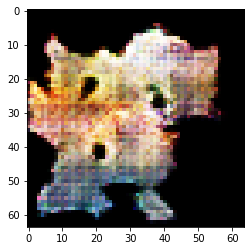

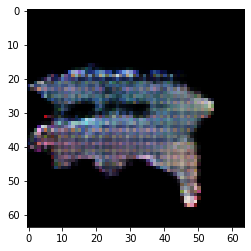

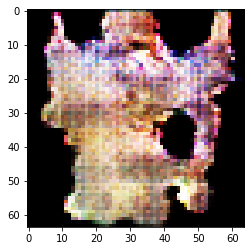

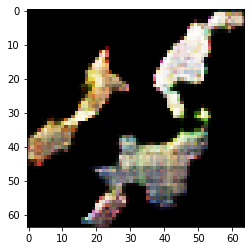

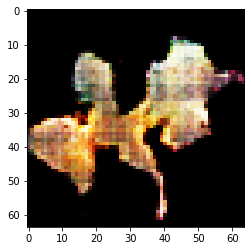

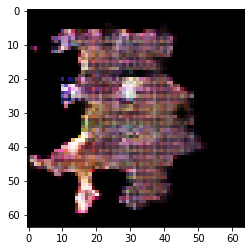

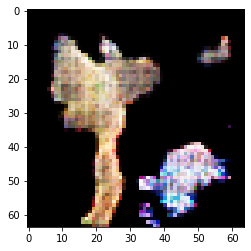

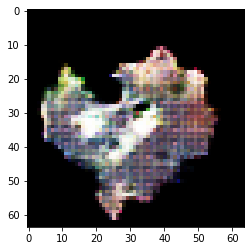

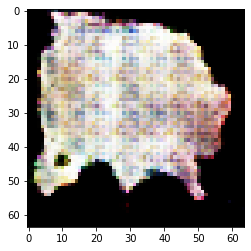

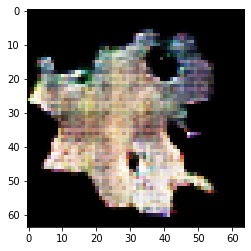

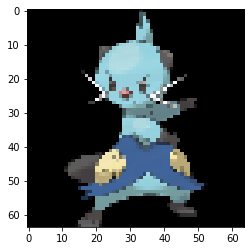

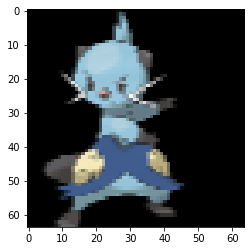

In [65]:
# wgan.load_weights(f"./pokemon/weights/wgan_gp/wgan_gp_model_lr_{lr}.h5")
gen_images(wgan.layers[1], codings_size = codings_size, n = 10)
show_image(pokemon_list[:2])
# wgan.save_weights(f"./pokemon/weights/wgan_gp/wgan_gp_model_lr_{lr}.h5")

# Essaie avec un autoencodeur variationnel

In [104]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 
K = keras.backend

train_set = dataset.take(200).map(lambda x: (x,x)).batch(32, drop_remainder=True).prefetch(1)
valid_set = dataset.skip(200).map(lambda x: (x,x)).batch(32, drop_remainder=True).prefetch(1)

codings_size = 100
inputs = keras.layers.Input(shape=[resize, resize, 3])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
# On se trouve avant la couche de codage

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(resize * resize * 3, activation="sigmoid")(x)
outputs = keras.layers.Reshape([resize, resize, 3])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])


_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / (resize * resize))
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = variational_ae.fit(train_set, epochs=100, batch_size=32,
                             validation_data=valid_set)
                             

Epoch 1/100
6/6 [==============================] - 1s 87ms/step - loss: 380017.3704 - accuracy: 0.3442 - val_loss: 240.4963 - val_accuracy: 0.3333
Epoch 2/100
6/6 [==============================] - 0s 52ms/step - loss: 48.1562 - accuracy: 0.3384 - val_loss: 18.9420 - val_accuracy: 0.3548
Epoch 3/100
6/6 [==============================] - 0s 50ms/step - loss: 20.8686 - accuracy: 0.3537 - val_loss: 6.3521 - val_accuracy: 0.3565
Epoch 4/100
6/6 [==============================] - 0s 51ms/step - loss: 3.2566 - accuracy: 0.3611 - val_loss: 4.4019 - val_accuracy: 0.3812
Epoch 5/100
6/6 [==============================] - 0s 54ms/step - loss: 4.2535 - accuracy: 0.3812 - val_loss: 2.9701 - val_accuracy: 0.3891
Epoch 6/100
6/6 [==============================] - 0s 56ms/step - loss: 1.8724 - accuracy: 0.3792 - val_loss: 2.4511 - val_accuracy: 0.3784
Epoch 7/100
6/6 [==============================] - 0s 54ms/step - loss: 2.5556 - accuracy: 0.3973 - val_loss: 1.9138 - val_accuracy: 0.4030
Epoch 8/10

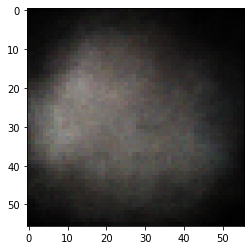

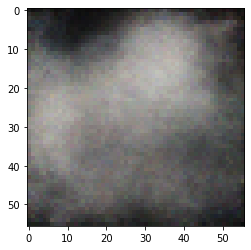

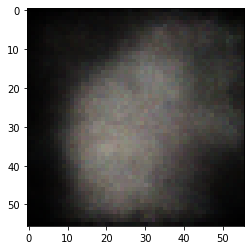

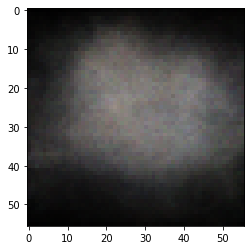

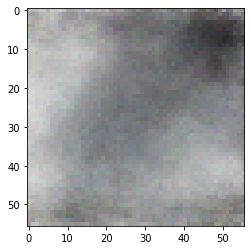

In [106]:
# def gen_images(model, codings_size=codings_size, n=5):
#     noises = tf.random.normal([n, codings_size])
#     generated = model(noises).numpy()
#     show_image(generated)
    
gen_images(variational_decoder,codings_size=codings_size, n=5)

In [ ]:
# Fusionnons 2 pokemons
def fusion(img1, img2, encoder, decoder):
    encod1 = encoder(img1)
    encod2 = encoder(img2)

    n = encod1.shape[0]
    ones = tf.random.uniform([n])


    fusion = encod1 + encod2
    fusion_img = decoder(fusion)
    plt.figure()
    plt.subplot(131)
    plt.imshow(img1)
    plt.subplot(132)
    plt.imshow(img2)
    plt.subplot(133)
    plt.imshow(fusion_img)

def fusion_batch(liste, encoder, decoder):
    n = len(liste)
    for i in range(n-1):
        fusion(list[i], list[i+1], encoder, decoder)




